# Density estimation using Real NVP

**Authors:** [Mandolini Giorgio Maria](https://www.linkedin.com/in/giorgio-maria-mandolini-a2a1b71b4/), [Sanna Daniele](https://www.linkedin.com/in/daniele-sanna-338629bb/), [Zannini Quirini Giorgio](https://www.linkedin.com/in/giorgio-zannini-quirini-16ab181a0/)<br>
**Date created:** 2020/08/10<br>
**Last modified:** 2020/08/10<br>
**Description:** Estimating the density distribution of the "double moon" dataset.

## Introduction

The aim of this work is to map a simple distribution - which is easy to sample
and whose density is simple to estimate - to a more complex one learned from the data.
This kind of generative model is also known as "normalizing flow".

In order to do this, the model is trained via the maximum
likelihood principle, using the "change of variable" formula.

We will use an affine coupling function. We create it such that its inverse, as well as
the determinant of the Jacobian, are easy to obtain (more details in the referenced paper).

**Requirements:**

* Tensorflow 2.9.1
* Tensorflow probability 0.17.0

**Reference:**

[Density estimation using Real NVP](https://arxiv.org/abs/1605.08803)

## Setup

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.datasets import make_moons
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

## Load the data

In [2]:
data = make_moons(3000, noise=0.05)[0].astype("float32")
norm = layers.Normalization()
norm.adapt(data)
normalized_data = norm(data)

## Affine coupling layer

In [3]:
# Creating a custom layer with keras API.
output_dim = 256
reg = 0.01


def Coupling(input_shape):
    input = keras.layers.Input(shape=input_shape)

    t_layer_1 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(input)
    t_layer_2 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_1)
    t_layer_3 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_2)
    t_layer_4 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_3)
    t_layer_5 = keras.layers.Dense(
        input_shape, activation="linear", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_4)

    s_layer_1 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(input)
    s_layer_2 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_1)
    s_layer_3 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_2)
    s_layer_4 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_3)
    s_layer_5 = keras.layers.Dense(
        input_shape, activation="tanh", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_4)

    return keras.Model(inputs=input, outputs=[s_layer_5, t_layer_5])


## Real NVP

In [4]:

class RealNVP(keras.Model):
    def __init__(self, num_coupling_layers):
        super().__init__()

        self.num_coupling_layers = num_coupling_layers

        # Distribution of the latent space.
        self.distribution = tfp.distributions.MultivariateNormalDiag(
            loc=[0.0, 0.0], scale_diag=[1.0, 1.0]
        )
        self.masks = np.array(
            [[0, 1], [1, 0]] * (num_coupling_layers // 2), dtype="float32"
        )
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.layers_list = [Coupling(2) for i in range(num_coupling_layers)]

    @property
    def metrics(self):
        """List of the model's metrics.

        We make sure the loss tracker is listed as part of `model.metrics`
        so that `fit()` and `evaluate()` are able to `reset()` the loss tracker
        at the start of each epoch and at the start of an `evaluate()` call.
        """
        return [self.loss_tracker]

    def call(self, x, training=True):
        log_det_inv = 0
        direction = 1
        if training:
            direction = -1
        for i in range(self.num_coupling_layers)[::direction]:
            x_masked = x * self.masks[i]
            reversed_mask = 1 - self.masks[i]
            s, t = self.layers_list[i](x_masked)
            s *= reversed_mask
            t *= reversed_mask
            gate = (direction - 1) / 2
            x = (
                reversed_mask
                * (x * tf.exp(direction * s) + direction * t * tf.exp(gate * s))
                + x_masked
            )
            log_det_inv += gate * tf.reduce_sum(s, [1])

        return x, log_det_inv

    # Log likelihood of the normal distribution plus the log determinant of the jacobian.

    def log_loss(self, x):
        y, logdet = self(x)
        log_likelihood = self.distribution.log_prob(y) + logdet
        return -tf.reduce_mean(log_likelihood)

    def train_step(self, data):
        with tf.GradientTape() as tape:

            loss = self.log_loss(data)

        g = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(g, self.trainable_variables))
        self.loss_tracker.update_state(loss)

        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self.log_loss(data)
        self.loss_tracker.update_state(loss)

        return {"loss": self.loss_tracker.result()}


## Model training

In [10]:
model = RealNVP(num_coupling_layers=6)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001))

history = model.fit(
    normalized_data, batch_size=256, epochs=300, verbose=2, validation_split=0.2
)

Epoch 1/300
10/10 - 22s - loss: 2.6844 - val_loss: 2.6661 - 22s/epoch - 2s/step
Epoch 2/300
10/10 - 0s - loss: 2.5906 - val_loss: 2.6173 - 204ms/epoch - 20ms/step
Epoch 3/300
10/10 - 0s - loss: 2.5349 - val_loss: 2.5655 - 200ms/epoch - 20ms/step
Epoch 4/300
10/10 - 0s - loss: 2.4944 - val_loss: 2.5270 - 207ms/epoch - 21ms/step
Epoch 5/300
10/10 - 0s - loss: 2.4721 - val_loss: 2.4874 - 206ms/epoch - 21ms/step
Epoch 6/300
10/10 - 0s - loss: 2.4445 - val_loss: 2.4517 - 204ms/epoch - 20ms/step
Epoch 7/300
10/10 - 0s - loss: 2.4121 - val_loss: 2.4147 - 232ms/epoch - 23ms/step
Epoch 8/300
10/10 - 0s - loss: 2.3863 - val_loss: 2.3819 - 203ms/epoch - 20ms/step
Epoch 9/300
10/10 - 0s - loss: 2.3523 - val_loss: 2.3466 - 199ms/epoch - 20ms/step
Epoch 10/300
10/10 - 0s - loss: 2.3215 - val_loss: 2.3110 - 201ms/epoch - 20ms/step
Epoch 11/300
10/10 - 0s - loss: 2.2908 - val_loss: 2.2798 - 219ms/epoch - 22ms/step
Epoch 12/300
10/10 - 0s - loss: 2.2556 - val_loss: 2.2450 - 195ms/epoch - 19ms/step
Epoc

## Performance evaluation

94/94 [==============================] - 1s 7ms/step


(-2.0, 2.0)

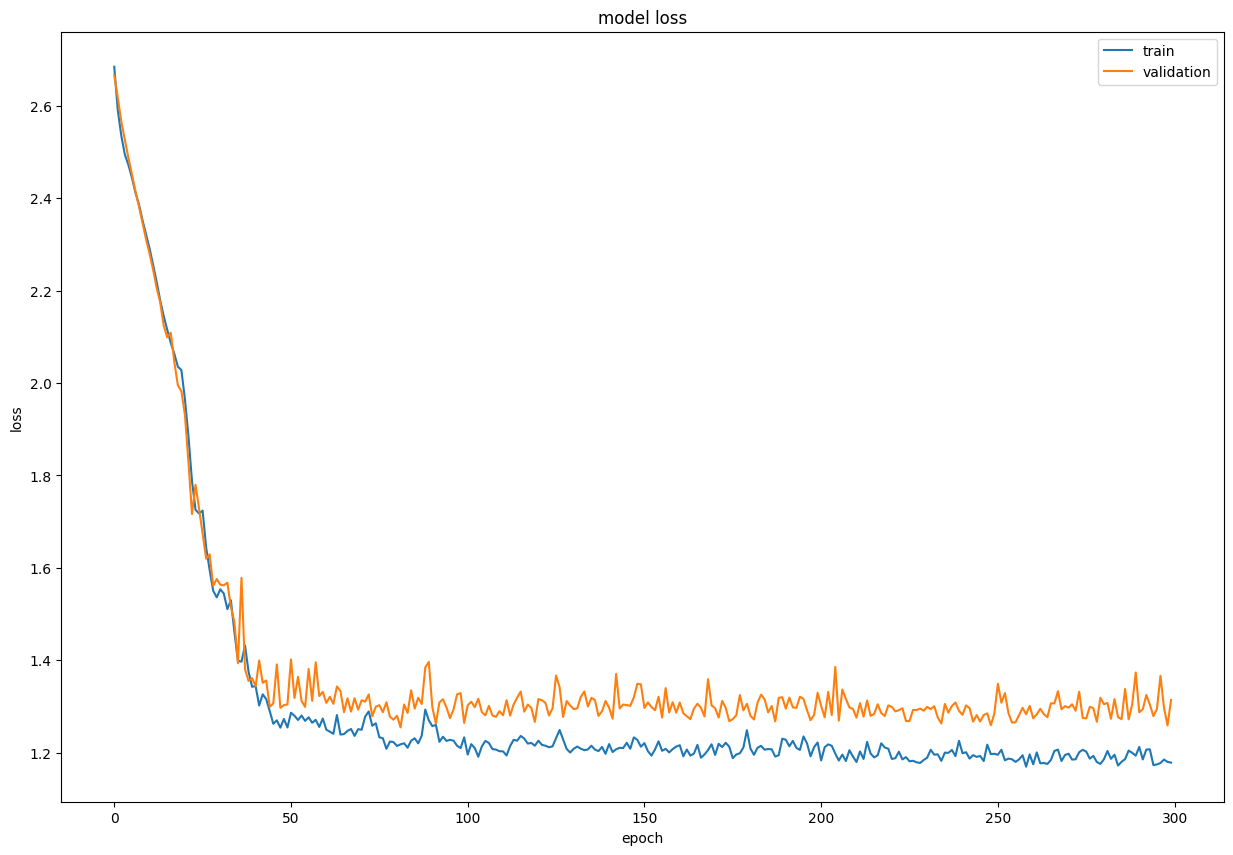

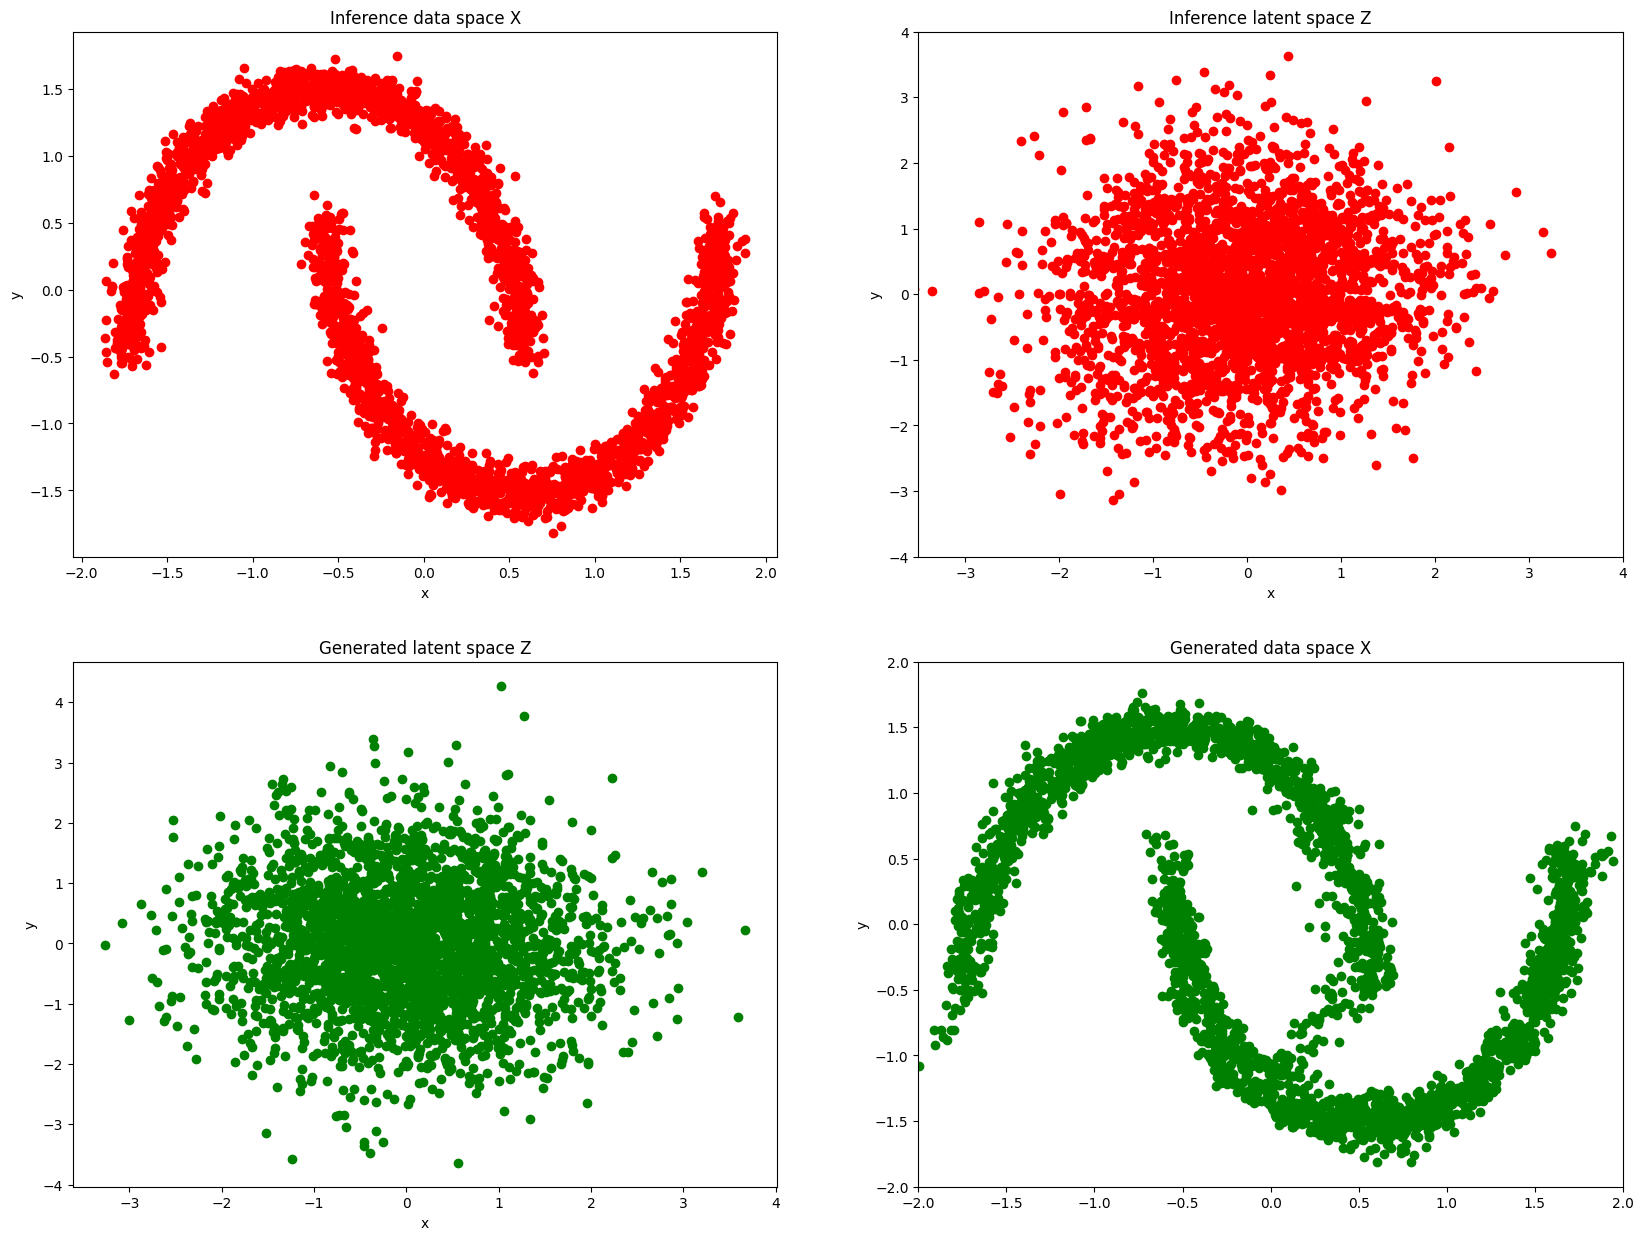

In [13]:
plt.figure(figsize=(15, 10))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.legend(["train", "validation"], loc="upper right")
plt.ylabel("loss")
plt.xlabel("epoch")

# From data to latent space.
z, _ = model(normalized_data)

# From latent space to data.
samples = model.distribution.sample(3000)
x, _ = model.predict(samples)

f, axes = plt.subplots(2, 2)
f.set_size_inches(20, 15)

axes[0, 0].scatter(normalized_data[:, 0], normalized_data[:, 1], color="r")
axes[0, 0].set(title="Inference data space X", xlabel="x", ylabel="y")
axes[0, 1].scatter(z[:, 0], z[:, 1], color="r")
axes[0, 1].set(title="Inference latent space Z", xlabel="x", ylabel="y")
axes[0, 1].set_xlim([-3.5, 4])
axes[0, 1].set_ylim([-4, 4])
axes[1, 0].scatter(samples[:, 0], samples[:, 1], color="g")
axes[1, 0].set(title="Generated latent space Z", xlabel="x", ylabel="y")
axes[1, 1].scatter(x[:, 0], x[:, 1], color="g")
axes[1, 1].set(title="Generated data space X", label="x", ylabel="y")
axes[1, 1].set_xlim([-2, 2])
axes[1, 1].set_ylim([-2, 2])